In [6]:
# Parameters
artificial_humans = {
    "full": {
        "contribution_model": "data/behavioral_cloning/20_contribution_model_v3/model/architecture_node+edge+rnn__dataset_full.pt",
        "valid_model": "data/behavioral_cloning/19_contribution_valid_model_v2/model/rnn_False__dataset_full.pt",
    },
}
managers = {
    "humanlike": {
        "type": "human",
        "path": "data/behavioral_cloning/18_punishment_autoregressive_v2/model/architecture_node+edge.pt",
        "autoregressive": True,
    },
    "optimal": {
        "type": "rl",
        "path": "data/manager/03_model/model/architecture_node+edge+rnn__run_0.pt",
    },
}
n_episode_steps = 16
n_episodes = 10
output_dir = "../../notebooks/test_manager/simulate_mixed/01_all"
basedir = "../.."


In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import os
import torch as th
import numpy as np
import seaborn as sns
import pandas as pd
import random
from itertools import count
from aimanager.utils.utils import make_dir

from aimanager.manager.memory import Memory
from aimanager.manager.environment import ArtificialHumanEnv

from aimanager.manager.api_manager import MultiManager
from aimanager.artificial_humans import GraphNetwork
from aimanager.utils.array_to_df import using_multiindex, add_labels

plot_folder = output_dir

make_dir(plot_folder)

managers = {k:{**v, 'path': os.path.join(basedir, v['path'])} for k,v in managers.items()}
managers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


{'humanlike': {'type': 'human',
  'path': '../../data/behavioral_cloning/18_punishment_autoregressive_v2/model/architecture_node+edge.pt',
  'autoregressive': True},
 'optimal': {'type': 'rl',
  'path': '../../data/manager/03_model/model/architecture_node+edge+rnn__run_0.pt'}}

In [ ]:
import re
import requests
import datetime
import os
import random
import numpy as np


BACKEND_URL = os.environ.get('MANAGER_BACKEND_URL', 'http://0.0.0.0:8000')


def get_punishments(contributions, missing_inputs, groups, *, session, group_idx, round):
    """
    Requests the punishments form the manger backend.

    Args:
        contributions [int]: contributions in fixed order (order has to remain throughout the game)
        missing_inputs [boolean]: missing_inputs in fixed order (same order as contributions)
        groups [str]: group identifier in fixed order (same order as contributions)
        session str: session indentifier
        subsession str: subsession identifier
        round int: round number

    Returns:
        [int]: punishments for each player in the same order then contributions
    """
    data = {
        'contributions': contributions,
        'missing_inputs': missing_inputs,
        'groups': groups,
        'round': round,
        'group_idx': group_idx,
        'session': session,
        'datetime': str(datetime.datetime.now())
    }
    url = BACKEND_URL + '/get_punishments'
    response = requests.post(url, json={'data': data}).json()
    return response

In [8]:
def mem_to_df(recorder, name):
    columns = ['episode','participant_code','round_number']

    punishments = using_multiindex(recorder.memory['punishment'].squeeze(1).numpy(), columns=columns, value_name='punishment')
    common_good = using_multiindex(recorder.memory['common_good'].squeeze(1).numpy(), columns=columns, value_name='common_good')
    contributions = using_multiindex(recorder.memory['contribution'].squeeze(1).numpy(), columns=columns, value_name='contribution')
    group = using_multiindex(recorder.memory['group'].squeeze(1).numpy(), columns=columns, value_name='group')

    df_sim = punishments.merge(common_good).merge(contributions).merge(group)

    df_sim['participant_code'] = df_sim['participant_code'].astype(str) + '_' + df_sim['episode'].astype(str)

    df_sim['run'] = name
    return df_sim

def make_round(contributions, round, groups, episode_group_idx):
    return {
        'contribution': contributions,
        'contribution_valid': [c is not None for c in contributions],
        'punishment_valid': [False] * len(contributions),
        'punishment': [None] * len(contributions),
        'group': groups,
        'round': round,
        'episode_group_idx': episode_group_idx
    }

def add_punishments(round, punishments):
    return {
        **round,
        'punishment': punishments,
        'punishment_valid': [p is not None for p in punishments],
    }


In [9]:
device = th.device('cpu')
rec_device = th.device('cpu')

mm = MultiManager(managers)

# fix bug
for k, man  in mm.managers.items():
    if 'autoregressive' in managers[k]:
        man.model.autoregressive = managers[k]['autoregressive']

runs = {
    f"ah {h} managed by {m}": {'groups': [m]*4, 'humans': h}
    for m in managers.keys()
    for h in artificial_humans.keys()
}

dfs = []
for name, run in runs.items():
    print(f'Start run {name}')

    random_session = str(random.randint(0, 1000000))

    groups = run['groups']
    n_agents = len(groups)

    hm_path = os.path.join(basedir, artificial_humans[run['humans']]['contribution_model'])
    hmv_path = os.path.join(basedir, artificial_humans[run['humans']]['valid_model'])

    ah = GraphNetwork.load(hm_path, device=device)
    ah_val = GraphNetwork.load(hmv_path, device=device)
    env = ArtificialHumanEnv(
        artifical_humans=ah, 
        artifical_humans_valid=ah_val, 
        n_agents=n_agents, n_contributions=21, n_punishments=31, 
        n_rounds=n_episode_steps, batch_size=1, device=device)
    recorder = Memory(
        n_episodes=n_episodes, n_episode_steps=n_episode_steps, output_file=None, device=device)
    for e in range(n_episodes):
        state = env.reset()
        episode_group_idx = random.randint(0,1000000)
        rounds = []
        for round_number in count():
            contributions = state['contribution'].squeeze().tolist()
            round = make_round(contributions, round_number, groups, episode_group_idx)
            punishments = mm.get_punishments(rounds+[round])[0]
            
            api_punishments = get_punishments(
                contributions, 
                [c is None for c in contributions], 
                groups, 
                session=random_session, 
                group_idx=episode_group_idx, 
                round=round_number)
            
            round = add_punishments(round, punishments)
            rounds.append(round)
            punishments = th.tensor(punishments, dtype=th.int64)
            api_punishments = th.tensor(api_punishments, dtype=th.int64).unsqueeze(-1).unsqueeze(0)
            state = env.punish(punishments.unsqueeze(-1).unsqueeze(0))
            recorder.add(
                **{k: v if len(v.shape) == 3 else v.unsqueeze(-1) for k, v in state.items()},
                api_punishments=api_punishments,
                episode_step=round_number)
            state, reward, done = env.step()
            if done:
                break
        recorder.next_episode(e)
    dfs.append(mem_to_df(recorder, name=name))
   

Start run ah human managed managed by humanlike
Start run ah full managed by humanlike
Start run ah human managed managed by optimal
Start run ah full managed by optimal


In [10]:
data_file = 'experiments/pilot_random1_player_round_slim.csv'
data_file = os.path.join(basedir, data_file)

df_pilot = pd.read_csv(data_file)

experiment_name_map = {
    'trail_rounds_2': 'pilot human manager',
    'random_1': 'pilot rule based manager'
}

df_pilot['run'] = df_pilot['experiment_name'].map(experiment_name_map)
df_pilot['common_good'] = df_pilot['common_good'] / 4
df_pilot = df_pilot[['round_number', 'common_good', 'contribution', 'participant_code', 'punishment', 'run', 'global_group_id' , 'api_punishments']]

df_pilot['api_punishment_delta'] = df_pilot['punishment'] - df_pilot['api_punishments']


df_pilot['episode'] = df_pilot['global_group_id']

df = pd.concat([*dfs, df_pilot]).reset_index(drop=True)

df['episode'] = df['run'] + '__' + df['episode'].astype(str)

dfm = df.melt(
    id_vars=['episode', 'round_number', 'participant_code', 'run'], 
    value_vars=['punishment', 'api_punishments', 'api_punishment_delta', 'contribution', 'common_good'])

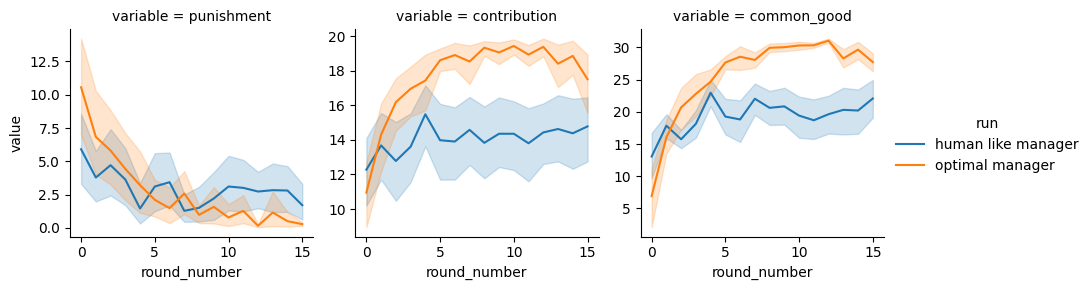

In [11]:
w = dfm['run'].isin([
    'ah full managed by optimal',
    'ah full managed by humanlike',
    # 'pilot human manager',
    # 'pilot rule based manager',
])

dfg = dfm[w].copy()
dfg['run'] = dfg['run'].map({
    'ah full managed by optimal': 'optimal manager',
    'ah full managed by humanlike': 'human like manager',
})


g = sns.relplot(
    data=dfg,
    x="round_number", 
    y="value",
    col='variable',
    hue='run',
    kind="line",
    facet_kws={'sharey': False, 'sharex': True},
    height=3, aspect=1,
)

g.savefig(os.path.join(plot_folder, 'comparison_manager.jpg'))

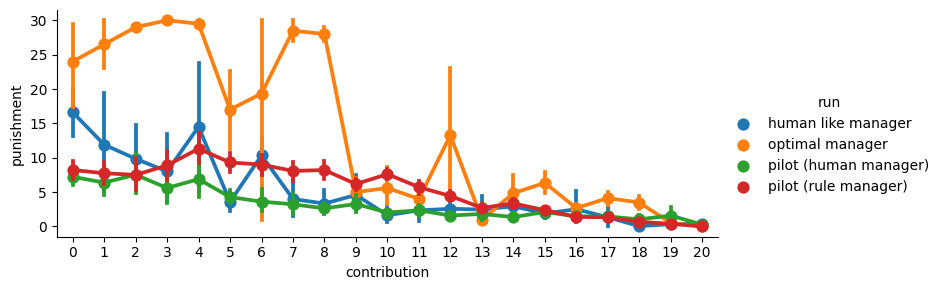

In [14]:
df['contribution'] = df['contribution'].astype(int)


w = df['run'].isin([
    'ah full managed by optimal',
    'ah full managed by humanlike',
    'pilot human manager',
    'pilot rule based manager',
])

dfs = df[w].copy()
dfs['run'] = dfs['run'].map({
    'ah full managed by optimal': 'optimal manager',
    'ah full managed by humanlike': 'human like manager',
    'pilot human manager': 'pilot (human manager)',
    'pilot rule based manager': 'pilot (rule manager)'
})


g = sns.catplot(
    data=dfs,
    x="contribution", 
    y="punishment",
    hue='run',
    kind="point",
    height=3, aspect=2.5,
)

g.savefig(os.path.join(plot_folder, 'comparison_pilot_policy.jpg'))

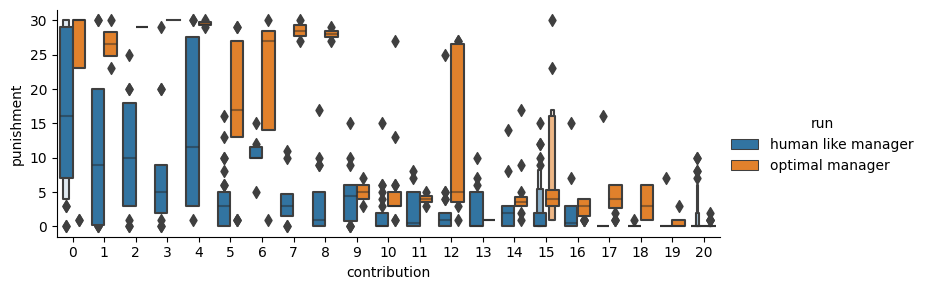

In [15]:
df['contribution'] = df['contribution'].astype(int)

w = df['run'].isin([
    'ah full managed by optimal',
    'ah full managed by humanlike',
    # 'pilot human manager',
    # 'pilot rule based manager',
])

dfs = df[w].copy()
dfs['run'] = dfs['run'].map({
    'ah full managed by optimal': 'optimal manager',
    'ah full managed by humanlike': 'human like manager',
    'pilot human manager': 'pilot (human manager)',
    'pilot rule based manager': 'pilot (rule manager)'
})


g = sns.catplot(
    data=dfs,
    x="contribution", 
    y="punishment",
    hue='run',
    kind="boxen",
    height=3, aspect=2.5,
)

g.savefig(os.path.join(plot_folder, 'comparison_pilot_policy_box.jpg'))

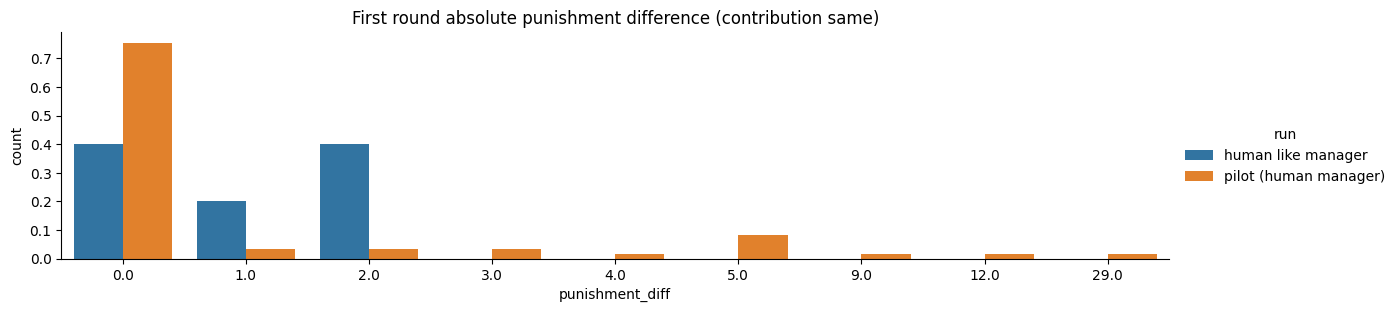

In [17]:
x,y = 'run', 'punishment_diff', 

w = dfm['contribution_same']

y_name = 'count'

((dfm[w]
.groupby(x)[y]
.value_counts(normalize=True)
.rename(y_name))
.reset_index()
.pipe((sns.catplot,'data'), x=y, y=y_name, hue=x,kind='bar', height=3, aspect=4))

plt.title('First round absolute punishment difference (contribution same)')
plt.savefig(os.path.join(plot_folder, 'first_round_punishment_difference.jpg'))
plt.show()
